In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from scipy.stats import poisson
import pyodbc
from heapq import nlargest
from statistics import mean
import operator

In [3]:
df = pd.read_excel(r'C:\Users\snappfood\Desktop\Poisson distribution\Result_39.xlsx')

In [4]:
#df.reset_index(inplace=True)

In [5]:
df['min_filt'] = df['number_of_trips'].rolling(60).mean()
df['hour_filt'] = df['number_of_trips'].rolling(3600).mean()

In [73]:
df.set_index(['time'],inplace=True)

(1.0, 20.0)

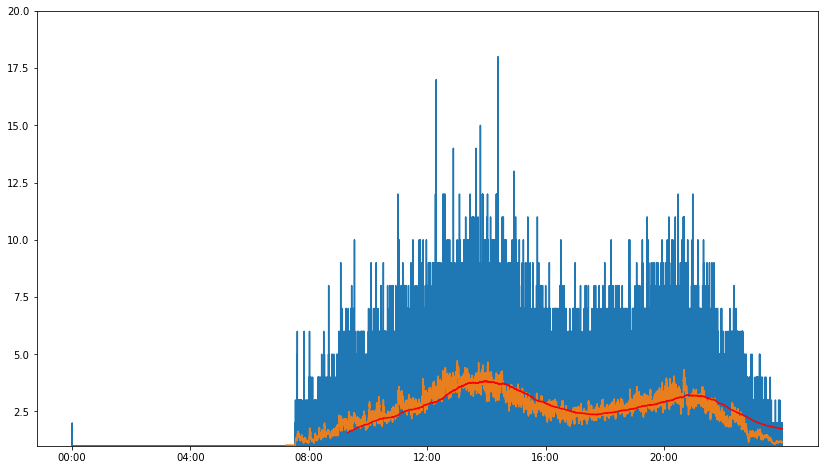

In [5]:
fig = plt.figure(figsize=(14,8))
ax= plt.plot(  df['time'] , df['number_of_trips']
            )
ax2 = plt.plot(df['time'] , df['min_filt'] ,alpha = 0.9)
ax3 = plt.plot(df['time'] , df['hour_filt'] , c='r')
xlim = np.arange(0, 60* 60 *24, 60*60*4)
plt.xticks(xlim, [str(n).zfill(2) + ':00' for n in np.arange(0, 24, 4)])
plt.ylim(1,20)


In [8]:
df.describe()

,time,number_of_trips,min_filt,hour_filt
count,49468.000000,49468.000000,49409.000000,45869.000000
mean,56747.891667,2.716928,2.718831,2.814015
std,15879.729632,1.639043,0.687841,0.538491
min,0.000000,1.000000,1.000000,1.576389
25%,43542.750000,1.000000,2.283333,2.441944
50%,56530.500000,2.000000,2.716667,2.778333
75%,70445.250000,4.000000,3.166667,3.174167
max,86398.000000,18.000000,4.716667,3.819444


In [25]:
def connection():
        server = '79.175.132.125,1410'
        database = 'express_db'
        username = 'ExpressAnalyst'
        password = '^cVGXN6q[nY#[-GE'
        Driver = 'SQL Server'
        cnxn = pyodbc.connect(
                'DRIVER={SQL Server};SERVER=' + server + ';DATABASE=' + database + ';UID=' + username + ';PWD=' + password)
        cursor = cnxn.cursor()
        return cursor 

In [26]:
x = dt.datetime.today()-dt.timedelta(200)
end_date = x-dt.timedelta(1)
start_date = x - dt.timedelta(2)
end_date_str=end_date.date().strftime('%Y-%m-%d' )
start_date_str= start_date.strftime('%Y-%m-%d')

In [27]:
query_1=f"""select datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at) as sec , count(distinct t.id) as trips from express_db..trip t
where t.created_at >= '{start_date_str}' and t.created_at < '{end_date_str}' and t.city_id = 1 and client_id <> 14
group by datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at)
order by datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at)"""


query_2 = f"""select datepart(hour , o.created_at)*3600 + datepart(minute , o.created_at)*60 + datepart(second ,o.created_at) ,count(distinct t.id),count(distinct o.id) from marketing_db..Orders o 
left join express_db..trip t on t.zf_order_id = o.id 
where o.status_id = 123 and t.city_id = 1 and t.client_id <> 14 and o.created_at >= '{start_date_str}'  and o.created_at < '{end_date_str}' and t.trip_status='DELIVERED'
group by datepart(hour , o.created_at)*3600 + datepart(minute , o.created_at)*60 + datepart(second ,o.created_at)
order by datepart(hour , o.created_at)*3600 + datepart(minute , o.created_at)*60 + datepart(second ,o.created_at) """
cursor=connection()
cursor.execute(query_1)
online_data=cursor.fetchall()
df = pd.DataFrame.from_records( online_data , columns = ['time' , 'trips' ] )

In [16]:
def fetch(start_date_str , end_date_str):
    query_1=f"""select cast(t.created_at as date), datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at) as sec , count(distinct t.id) as trips from express_db..trip t
    where t.created_at >= '{start_date_str}' and t.created_at < '{end_date_str}' and t.city_id = 1 and client_id <> 14
    group by datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at), cast(t.created_at as date)
    order by datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at)"""


    query_2 = f"""Select cast(o.created_at as date) as date,datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at) as sec,count(distinct o.id),count(distinct t.id) from marketing_db.dbo.Orders as o
                left join marketing_db.dbo.Vendors as v on v.id=o.vendor_id
                left join express_db.dbo.trip as t on o.id=t.zf_order_id and t.created_at >= '{start_date_str}'  and t.created_at < '{end_date_str}' and t.trip_status='delivered'
                where o.created_at >= '{start_date_str}' and o.created_at < '{end_date_str}'
                and v.CityID=1
                group by cast(o.created_at as date) , datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at)
                order by datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at)"""
    
    cursor=connection()
    cursor.execute(query_2)
    online_data=cursor.fetchall()
    df = pd.DataFrame.from_records( online_data , columns = ['date','time' ,'orders' , 'trips' ] )
    return df

In [17]:
fetch(start_date_str , end_date_str)

,date,time,orders,trips
0,2021-11-16,NaN,81591,0
1,2021-11-16,141.0,1,1
2,2021-11-16,411.0,1,1
3,2021-11-16,25326.0,1,1
4,2021-11-16,25743.0,1,1
...,...,...,...,...
41102,2021-11-16,86289.0,1,1
41103,2021-11-16,86316.0,1,1
41104,2021-11-16,86348.0,1,1
41105,2021-11-16,86370.0,1,1


In [28]:
df['filt_t'] = df['trips'].rolling(60).mean()
#df['filt_o'] = df['orders'].rolling(60).mean()

In [29]:
def check_day(cheking_date):
    
    date = cheking_date.strftime('%m/%d/%Y')
    day = str(int(date.split('/')[1]))
    month = str(int(date.split('/')[0]))
    year = date.split('/')[2]
    
    date = f'{month}/{day}/{year}'
        
        
    query_3 = f""" select * from Analytics..Express_PersianCalendar1400 c
                where c.Miladi_Date = '{date}' """
    
    cursor=connection()
    cursor.execute(query_3)
    online_data=cursor.fetchall()
    status = pd.DataFrame.from_records( online_data , columns = ['_' , '_' , 'day name' , '_' , 'miladi date' , '_' , 'status' , '_'])
    
    return status['status'][0]


In [30]:
def similar_dates(date , n):
    list_of_similar = []
    for i in range(1,20):
        j = date + dt.timedelta(i)
        if check_day(j)==check_day(date) and len(list_of_similar) < n:
            list_of_similar.append(j.date())
        else:
            pass
    return list_of_similar    

In [31]:
sim_days = similar_dates(x , 7)



In [25]:
check_day(x)

'NormalDay'

In [28]:
#import operator
#sorted_tuples = sorted(A.items(), key=operator.itemgetter(0))
#dict(sorted_tuples)

{1: 0.327,
 2: 0.256,
 3: 0.134,
 4: 0.052,
 5: 0.016,
 6: 0.004,
 7: 0.001,
 8: 0.0,
 10: 0.0}

In [ ]:
#min 
X= list(range(31000 ,df['time'].max() ,3600 )) #hourly
for i in range(0 , len(X)-1):
    filt = (df['time'] >= X[i] ) & (df['time']< X[i+1])
    lam = df[filt]['filt_t'].mean()
    k = df[filt]['filt_t'].to_list()
    pmf = poisson.pmf(k, mu=lam)
    pmf = np.round(pmf, 2)
    k = np.round(k , 2)
    probabilty = dict(zip(k , pmf)) 
    print(probabilty)
    res =nlargest(2,probabilty, key = probabilty.get)
    #print(res)
    
    #df.loc[filt , 'H_P'] = res[0]
   
  #  df.loc[filt,'L_P'] = res[1]
    

    
#df = df[df['H_P']!=0]

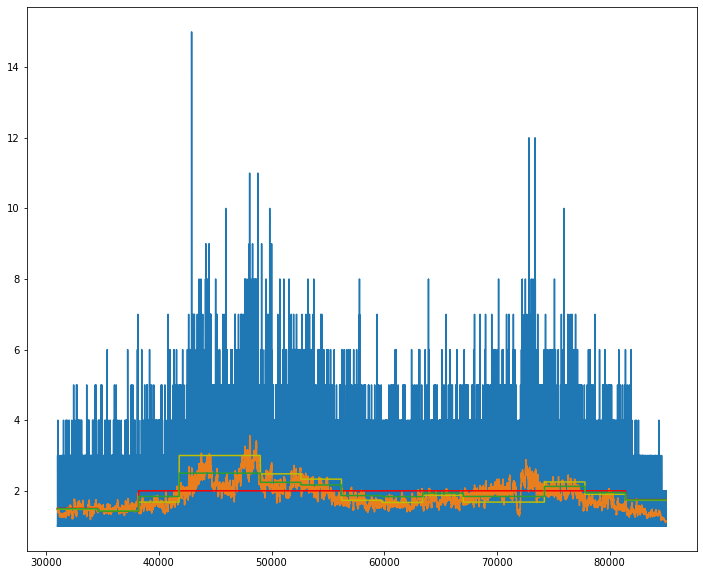

In [47]:
fig = plt.figure(figsize=(12,10))
ax= plt.plot(  df['time'] , df['trips'])
ax2 = plt.plot(df['time'] , df['filt_t'] ,alpha = 0.9)
ax3 = plt.plot(df['time'] , df['H_P'] , c='r')
ax4= plt.plot(df['time'] , df['L_P'] , c='y')
ax5 = plt.plot(df['time'] , df['mean'] )

In [156]:
#sec
X= list(range(27000 ,df['time'].max() ,600 )) #minute
for i in range(0 , len(X)-1):
    filt = (df['time'] >= X[i] ) & (df['time']< X[i+1])
    lam = df[filt]['trips'].mean()
    k = df[filt]['trips'].to_list()
    k = np.round(k , 2)
    pmf = poisson.pmf(k, mu=lam)
    pmf = np.round(pmf, 2)
    
    probabilty = dict(zip(k , pmf)) 
    
    res =nlargest(3,probabilty, key = probabilty.get)
    #df.loc[filt , 'H_P'] = res[0]
    print(probabilty)
    #df.loc[filt,'L_P'] = res[1]
    

    
#df = df[df['H_P']!=0]

{2: 0.27, 1: 0.26, 3: 0.19, 4: 0.1, 6: 0.01, 5: 0.04, 8: 0.0}
{1: 0.34, 2: 0.25, 3: 0.12, 4: 0.05, 5: 0.01}
{2: 0.25, 3: 0.12, 1: 0.34, 6: 0.0, 5: 0.01, 4: 0.04}
{1: 0.33, 2: 0.25, 3: 0.13, 5: 0.01, 4: 0.05}
{2: 0.26, 1: 0.32, 3: 0.14, 4: 0.05, 5: 0.02}
{3: 0.13, 1: 0.33, 2: 0.26, 5: 0.02, 4: 0.05}
{1: 0.31, 3: 0.15, 2: 0.27, 4: 0.07, 5: 0.02, 7: 0.0}
{1: 0.3, 2: 0.27, 5: 0.02, 3: 0.16, 6: 0.01, 4: 0.07}
{1: 0.3, 5: 0.02, 2: 0.27, 3: 0.16, 4: 0.07, 6: 0.01}
{1: 0.27, 2: 0.27, 3: 0.18, 4: 0.09, 5: 0.04, 6: 0.01, 7: 0.0}
{2: 0.27, 3: 0.18, 1: 0.27, 5: 0.04, 4: 0.09, 7: 0.0, 6: 0.01}
{2: 0.27, 1: 0.28, 3: 0.18, 4: 0.09, 5: 0.03, 8: 0.0}
{1: 0.26, 3: 0.19, 2: 0.27, 4: 0.1, 5: 0.04, 6: 0.01}
{3: 0.18, 4: 0.09, 2: 0.27, 1: 0.26, 5: 0.04, 7: 0.0, 6: 0.01}
{2: 0.27, 1: 0.26, 4: 0.1, 3: 0.19, 7: 0.0, 5: 0.04, 6: 0.01}
{1: 0.24, 2: 0.27, 3: 0.2, 4: 0.11, 5: 0.05, 6: 0.02, 7: 0.01}
{4: 0.1, 1: 0.25, 3: 0.19, 2: 0.27, 5: 0.04, 6: 0.02, 7: 0.0, 8: 0.0}
{6: 0.01, 4: 0.1, 1: 0.26, 2: 0.27, 3: 0.19, 5

In [32]:
def lam (sim_days):
    
    dict1 = {}
    for day in sim_days:
        
        start_date = day 
        end_date = start_date + dt.timedelta(1)
        end_date_str=end_date.strftime('%Y-%m-%d' )
        start_date_str= start_date.strftime('%Y-%m-%d')
        
        
        query = f"""select datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at) as sec , count(distinct t.id) as trips from express_db..trip t
                where t.created_at >= '{start_date_str}' and t.created_at < '{end_date_str}' and t.city_id = 1 and client_id <> 14
                group by datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at)
                order by datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at)"""
        cursor=connection()
        cursor.execute(query)
        online_data=cursor.fetchall()
        df = pd.DataFrame.from_records( online_data , columns = ['time' , 'trips' ])
        df['filt_t'] = df['trips'].rolling(60).mean()
        
        df.fillna(0)
        
        #print(df.head(5))
        X = list(range(27000 ,86400 ,600 )) # 7:30 ~ 24
        for i in range(0 , len(X)-1):
            filt = (df['time'] >= X[i] ) & (df['time']< X[i+1])
            lam = df[filt]['trips'].mean()
            lam = np.round(lam , 3)

            dict1.setdefault(X[i] , [lam]) 
            dict1[X[i]] += [lam]
            
    dict2={}
    for i in dict1.keys():
        dict2.setdefault(i ,np.round(mean(dict1[i]) , 1))
        
    dict3={}
    for i in dict1.keys():
        dict3.setdefault(i , [max(dict1[i]) , min(dict1[i])])
    
    
            

    return dict2 ,dict1 , dict3

    

In [33]:
B , A , C= lam(sim_days)



In [34]:
ma = [C[i][0] for i in C.keys()]
mi = [C[i][1] for i in C.keys()]

In [65]:
df.fillna(0, inplace=True)

In [41]:
dict3 = {}

X= list(range(27000 ,86400 ,3600 )) #hourly
for i in range(0 , len(X)-1):
    filt = (df['time'] >= X[i] ) & (df['time']< X[i+1])
    #lam1 = df[filt]['filt_t'].mean()
    lam = B[X[i]]
    #lam3 = np.round((lam1 + lam2 )/2,1)
    k = df[filt]['trips'].to_list()
    #k=list(set(k))
    pmf = poisson.pmf(k, mu=lam)
    pmf = np.round(pmf, 2)
    k = np.round(k , 1)
    #print(k)
    #print(lam)
    probabilty = dict(zip(k , pmf)) 
    print(probabilty)
    res =nlargest(2,probabilty, key = probabilty.get)
    dict3.setdefault(X[i] , (res[0]+res[1])/2)
    #dict4.setdefault(X[i] , res[1])
    
    

{1: 0.35, 2: 0.23, 3: 0.1, 5: 0.01, 4: 0.03}
{1: 0.35, 3: 0.11, 2: 0.24, 4: 0.04, 5: 0.01, 8: 0.0, 6: 0.0}
{1: 0.3, 2: 0.27, 5: 0.03, 4: 0.07, 3: 0.16, 6: 0.01, 7: 0.0}
{1: 0.27, 3: 0.18, 2: 0.27, 4: 0.09, 5: 0.04, 6: 0.01, 7: 0.0}
{2: 0.27, 1: 0.27, 3: 0.18, 7: 0.0, 6: 0.01, 4: 0.09, 5: 0.04, 8: 0.0, 9: 0.0, 11: 0.0}
{6: 0.01, 2: 0.27, 5: 0.04, 1: 0.26, 3: 0.19, 4: 0.1, 7: 0.0, 8: 0.0, 9: 0.0}
{3: 0.21, 4: 0.13, 1: 0.21, 6: 0.03, 2: 0.26, 7: 0.01, 8: 0.0, 5: 0.07, 9: 0.0}
{1: 0.22, 3: 0.21, 6: 0.02, 2: 0.26, 4: 0.13, 5: 0.06, 7: 0.01, 8: 0.0, 11: 0.0, 9: 0.0}
{1: 0.28, 4: 0.08, 3: 0.17, 2: 0.27, 6: 0.01, 5: 0.03, 7: 0.0, 8: 0.0}
{3: 0.16, 1: 0.3, 2: 0.27, 4: 0.07, 5: 0.03, 6: 0.01, 7: 0.0, 8: 0.0}
{5: 0.02, 2: 0.26, 1: 0.31, 7: 0.0, 3: 0.15, 4: 0.06, 6: 0.01, 8: 0.0}
{3: 0.17, 1: 0.28, 2: 0.27, 4: 0.08, 6: 0.01, 5: 0.03, 7: 0.0, 10: 0.0, 8: 0.0}
{2: 0.27, 1: 0.27, 4: 0.09, 3: 0.18, 5: 0.04, 9: 0.0, 7: 0.0, 8: 0.0, 6: 0.01, 11: 0.0, 10: 0.0}
{5: 0.04, 3: 0.18, 1: 0.27, 2: 0.27, 4: 0.09

In [36]:
q={1: 0.27, 3: 0.18, 4: 0.09, 5: 0.04, 2: 0.27, 6: 0.01, 7: 0.0}
sorted_tuples = sorted(q.items(), key=operator.itemgetter(0))
q=dict(sorted_tuples)
p = 0
for i in q.keys():
    
    if p<=0.6:
        print(i , q[i])
        p+=q[i]
print(p)

1 0.27
2 0.27
3 0.18
0.72


In [22]:

sorted_tuples = sorted(q.items(), key=operator.itemgetter(0))
q=dict(sorted_tuples)
q

{1: 0.27, 2: 0.27, 3: 0.18, 4: 0.09, 5: 0.04, 6: 0.01, 7: 0.0}

In [162]:
max(set(k), key=k.count)

1.1

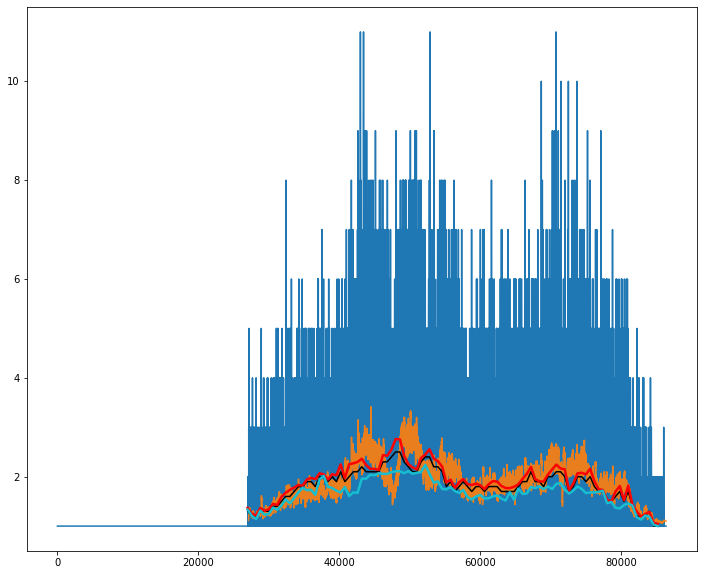

In [19]:
fig = plt.figure(figsize=(12,10))
ax= plt.plot(  df['time'] , df['trips'])
ax2 = plt.plot(df['time'] , df['filt_t'] ,alpha = 0.9)
ax3 = plt.plot(B.keys() , B.values() ,c='black')
ax4 = plt.plot(C.keys() , ma , c='r',linewidth=2.5)
ax5 = plt.plot(C.keys() , mi ,c='#17becf' ,linewidth=2.5)

#ax4 = plt.plot(dict4.keys() , dict4.values() , c='y')

In [165]:
def probability(Date):
    start_date_str = Date.strftime('%Y-%m-%d' )
    end_date_str = Date + dt.timedelta(1)
    end_date_str = end_date_str.strftime('%Y-%m-%d' )
    
    
    query_1=f"""select datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at) as sec , count(distinct t.id) as trips from express_db..trip t
            where t.created_at >= '{start_date_str}' and t.created_at < '{end_date_str}' and t.city_id = 1 and client_id <> 14
            group by datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at)
            order by datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at)"""
        
    cursor=connection()
    cursor.execute(query_1)
    online_data=cursor.fetchall()
    df = pd.DataFrame.from_records( online_data , columns = ['time' , 'trips' ])
    
    
    X= list(range(27000 ,df['time'].max() ,600 )) #minute
    for i in range(0 , len(X)-1):
        filt = (df['time'] >= X[i] ) & (df['time']< X[i+1])
        lam = df[filt]['trips'].mean()
        k = df[filt]['trips'].to_list()
        k = np.round(k , 2)
        pmf = poisson.pmf(k, mu=lam)
        pmf = np.round(pmf, 2)

        probabilty = dict(zip(k , pmf)) 

        res =nlargest(2,probabilty, key = probabilty.get)
        
        
        
    return res

In [166]:
list(map( probability,sim_days ))

[[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2], [1, 2, 3], [1, 2]]

datetime.date(2021, 5, 31)

In [50]:
arrays = [sim_days , list(range(27000 ,df['time'].max() ,600 ))]

In [77]:
df

,time,trips,H_P,filt_t,L_P
0,4,1,1,NaN,0
1,65,1,1,NaN,0
2,115,1,1,NaN,0
3,123,1,1,NaN,0
4,130,1,1,NaN,0
...,...,...,...,...,...
39207,86147,1,0,1.100000,0
39208,86235,1,0,1.100000,0
39209,86236,1,0,1.100000,0
39210,86300,1,0,1.066667,0


In [84]:
df.index = pd.MultiIndex.from_arrays([df['date'], df['time']], names=['date','time'])

In [78]:
df= fetch(start_date_str , end_date_str)
    

In [82]:
df.index

RangeIndex(start=0, stop=39212, step=1)

In [85]:
df

date   time  trips
date       time                           
2022-05-30 4      2022-05-30      4      1
           65     2022-05-30     65      1
           115    2022-05-30    115      1
           123    2022-05-30    123      1
           130    2022-05-30    130      1
...                      ...    ...    ...
           86147  2022-05-30  86147      1
           86235  2022-05-30  86235      1
           86236  2022-05-30  86236      1
           86300  2022-05-30  86300      1
           86314  2022-05-30  86314      1

[39212 rows x 3 columns]

In [86]:
df.index

MultiIndex([('2022-05-30',     4),
            ('2022-05-30',    65),
            ('2022-05-30',   115),
            ('2022-05-30',   123),
            ('2022-05-30',   130),
            ('2022-05-30', 23776),
            ('2022-05-30', 25366),
            ('2022-05-30', 25584),
            ('2022-05-30', 25607),
            ('2022-05-30', 25636),
            ...
            ('2022-05-30', 86047),
            ('2022-05-30', 86068),
            ('2022-05-30', 86084),
            ('2022-05-30', 86105),
            ('2022-05-30', 86138),
            ('2022-05-30', 86147),
            ('2022-05-30', 86235),
            ('2022-05-30', 86236),
            ('2022-05-30', 86300),
            ('2022-05-30', 86314)],
           names=['date', 'time'], length=39212)

In [89]:
df1 = df.copy() 

In [92]:
df1['date'] = dt.date(2022,5,30)

In [94]:
df1.index = pd.MultiIndex.from_arrays([df1['date'], df1['time']], names=['date','time'])

In [95]:
df1

time  trips        date
date       time                           
2022-05-30 4          4      1  2022-05-30
           65        65      1  2022-05-30
           115      115      1  2022-05-30
           123      123      1  2022-05-30
           130      130      1  2022-05-30
...                 ...    ...         ...
           86147  86147      1  2022-05-30
           86235  86235      1  2022-05-30
           86236  86236      1  2022-05-30
           86300  86300      1  2022-05-30
           86314  86314      1  2022-05-30

[39212 rows x 3 columns]

In [111]:
df2 = df.copy()

In [112]:
df2['date'] = dt.date(2022,5,29)

In [113]:
df2.index= pd.MultiIndex.from_arrays([df2['date'], df2['time']], names=['date','time'])

In [114]:
df2

time  trips        date
date       time                           
2022-05-29 131      131      1  2022-05-29
           330      330      1  2022-05-29
           341      341      1  2022-05-29
           373      373      1  2022-05-29
           25226  25226      1  2022-05-29
...                 ...    ...         ...
           86366  86366      1  2022-05-29
           86373  86373      1  2022-05-29
           86375  86375      1  2022-05-29
           86381  86381      1  2022-05-29
           86396  86396      1  2022-05-29

[50455 rows x 3 columns]

In [116]:
df3 = pd.concat([df1, df2])

In [133]:
df3.loc[(dt.date(2022,5,29), 131)]


time            131
trips             1
date     2022-05-29
Name: (2022-05-29, 131), dtype: object

In [ ]:
def fetch(start_date_str , end_date_str):
    
    
    query_1=f"""select cast(t.created_at as date), datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at) as sec , count(distinct t.id) as trips from express_db..trip t
    where t.created_at >= '{start_date_str}' and t.created_at < '{end_date_str}' and t.city_id = 1 and client_id <> 14
    group by datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at), cast(t.created_at as date)
    order by datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at)"""


    query_2 = f"""select cast(o.created_at as date),datepart(hour , o.created_at)*3600 + datepart(minute , o.created_at)*60 + datepart(second ,o.created_at) ,count(distinct t.id),count(distinct o.id) from marketing_db..Orders o 
    left join express_db..trip t on t.zf_order_id = o.id 
    where o.status_id = 123 and t.city_id = 1 and t.client_id <> 14 and o.created_at >= '{start_date_str}'  and o.created_at < '{end_date_str}' and t.trip_status='DELIVERED'
    group by datepart(hour , o.created_at)*3600 + datepart(minute , o.created_at)*60 + datepart(second ,o.created_at) , cast(o.created_at as date)
    order by datepart(hour , o.created_at)*3600 + datepart(minute , o.created_at)*60 + datepart(second ,o.created_at) """
    cursor=connection()
    cursor.execute(query_1)
    online_data=cursor.fetchall()
    df = pd.DataFrame.from_records( online_data , columns = ['date','time' , 'trips' ] )
    return df

In [138]:
def fetch(sim_days):
    
    append_list= []
    for i in sim_days:
        
        start_date_str = i 
        end_date_str = i + dt.timedelta(1)
        end_date_str=end_date.date().strftime('%Y-%m-%d' )
        start_date_str= start_date.strftime('%Y-%m-%d')
        
        
        query = f"""select datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at) as sec , count(distinct t.id) as trips from express_db..trip t
                where t.created_at >= '{start_date_str}' and t.created_at < '{end_date_str}' and t.city_id = 1 and client_id <> 14
                group by datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at)
                order by datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at)"""
        cursor=connection()
        cursor.execute(query_1)
        online_data=cursor.fetchall()
        df = pd.DataFrame.from_records( online_data , columns = ['time' , 'trips' ])
        df['date'] = i 
        append_list.append(df)
    appened_data = pd.concat(append_list)
    return appened_data
        


In [142]:
df.index = pd.MultiIndex.from_arrays([df['date'], df['time']], names=['date','time'])

In [160]:
dataframe

time  trips        date
date       time                           
2021-06-01 131      131      1  2021-06-01
           330      330      1  2021-06-01
           341      341      1  2021-06-01
           373      373      1  2021-06-01
           25226  25226      1  2021-06-01
...                 ...    ...         ...
2021-06-10 86366  86366      1  2021-06-10
           86373  86373      1  2021-06-10
           86375  86375      1  2021-06-10
           86381  86381      1  2021-06-10
           86396  86396      1  2021-06-10

[353185 rows x 3 columns]